Results Section

- Dipole Auger + 2MRS Dipoles in >cz (with flux weight)
- Angular distance to Auger Dipole
- [Use full Sample]
---------------------

- Dipole Auger + 2MRS Dipoles in slices of cz (with flux weight)
- Angular distance to Auger Dipole
- [Use full Sample]
---------------------
- Galaxy-Flux correlation for different cz
- [Use sample with completeness]
---------------------

- G-F correlation at closest cz for different K
- [Use sample with completeness]



### Read Full Catalogue

In [5]:
"""
Read full 2MRS catalogue
"""

import numpy as np
from astropy.io import ascii
from astropy.table import Table

def read_catalog(path='../data/', 
                 name='2mrs_1175_done.dat', ncols=29):
  
  with open(path+name, 'r') as file:
    archivo = file.readlines()
    header  = [a.replace('#','').split() for a in archivo[:10]]
    lines   = archivo[10:]
  
  columns = header[-1]
  assert(len(columns) == ncols)
  print("Read %s\nColumns:" % name)
  print(columns)
  
  g = [[] for _ in range(ncols)]     
  for line in lines:
    values = line.split()
    g[0].append(            values[0]);   g[1].append(np.float32(values[1]));   g[2].append(np.float32(values[2]));
    g[3].append(np.float32( values[3]));  g[4].append(np.float32(values[4]));   g[5].append(np.float32(values[5]));
    g[6].append(np.float32( values[6]));  g[7].append(np.float32(values[7]));   g[8].append(np.float32(values[8]));
    g[9].append(np.float32( values[9]));  g[10].append(np.float32(values[10])); g[11].append(np.float32(values[11]));
    g[12].append(np.float32(values[12])); g[13].append(np.float32(values[13])); g[14].append(np.float32(values[14]));
    g[15].append(np.float32(values[15])); g[16].append(np.float32(values[16])); g[17].append(np.float32(values[17]));
    g[18].append(np.float32(values[18])); g[19].append(np.float32(values[19])); g[20].append(np.float32(values[20]));
    g[21].append(           values[21]) ; g[22].append(           values[22]);  g[23].append(values[23]); g[24].append(np.int32(values[24]));
    g[25].append(np.int32(  values[25])); g[26].append(           values[26]);  g[27].append(values[27]); g[28].append(         values[28])
  
  data = Table()
  for idx, col in enumerate(columns):
    data[col] = np.array(g[idx])

  return data

data = read_catalog()
print(data[:5])
print("Total number of galaxies:", len(data))
print("Columns in the data:", data.colnames)


Read 2mrs_1175_done.dat
Columns:
['ID', 'RAdeg', 'DECdeg', 'l', 'b', 'k_c', 'h_c', 'j_c', 'k_tc', 'h_tc', 'j_tc', 'e_k', 'e_h', 'e_j', 'e_kt', 'e_ht', 'e_jt', 'e_bv', 'r_iso', 'r_ext', 'b/a', 'flgs', 'type', 'ts', 'v', 'e_v', 'c', 'vsrc', 'CAT_ID']
       ID          RAdeg     DECdeg  ...  c          vsrc           CAT_ID  
---------------- --------- --------- ... --- ------------------- -----------
00424433+4116074  10.68471  41.26875 ...   N 1991RC3.9.C...0000d MESSIER_031
00473313-2517196  11.88806  -25.2888 ...   N 2004AJ....128...16K    NGC_0253
09553318+6903549 148.88826  69.06526 ...   N 1991RC3.9.C...0000d MESSIER_081
13252775-4301073 201.36565 -43.01871 ...   N 1978PASP...90..237G    NGC_5128
13052727-4928044 196.36366  -49.4679 ...   N 2004AJ....128...16K    NGC_4945
Total number of galaxies: 43533
Columns in the data: ['ID', 'RAdeg', 'DECdeg', 'l', 'b', 'k_c', 'h_c', 'j_c', 'k_tc', 'h_tc', 'j_tc', 'e_k', 'e_h', 'e_j', 'e_kt', 'e_ht', 'e_jt', 'e_bv', 'r_iso', 'r_ext', 'b/a', 

### Plot K vs cz

Read 2mrs_1175_done.dat
Columns:
['ID', 'RAdeg', 'DECdeg', 'l', 'b', 'k_c', 'h_c', 'j_c', 'k_tc', 'h_tc', 'j_tc', 'e_k', 'e_h', 'e_j', 'e_kt', 'e_ht', 'e_jt', 'e_bv', 'r_iso', 'r_ext', 'b/a', 'flgs', 'type', 'ts', 'v', 'e_v', 'c', 'vsrc', 'CAT_ID']


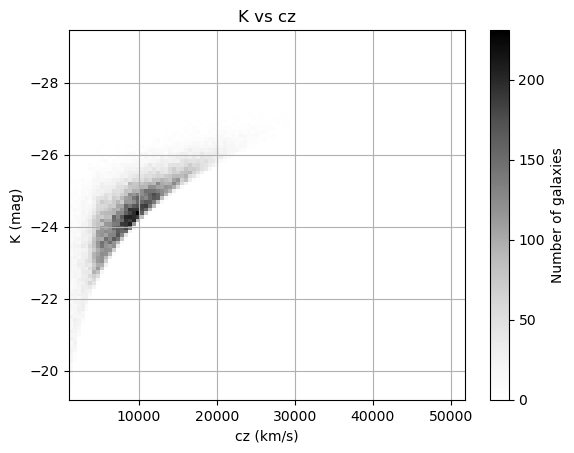

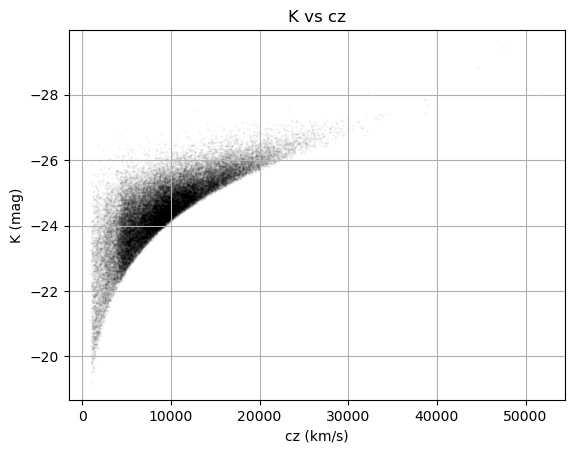

In [31]:
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import numpy as np
from astropy.io import ascii
from astropy.table import Table

def read_catalog(path='../data/', 
                 name='2mrs_1175_done.dat', ncols=29):
  
  with open(path+name, 'r') as file:
    archivo = file.readlines()
    header  = [a.replace('#','').split() for a in archivo[:10]]
    lines   = archivo[10:]
  
  columns = header[-1]
  assert(len(columns) == ncols)
  print("Read %s\nColumns:" % name)
  print(columns)
  
  g = [[] for _ in range(ncols)]     
  for line in lines:
    values = line.split()
    g[0].append(            values[0]);   g[1].append(np.float32(values[1]));   g[2].append(np.float32(values[2]));
    g[3].append(np.float32( values[3]));  g[4].append(np.float32(values[4]));   g[5].append(np.float32(values[5]));
    g[6].append(np.float32( values[6]));  g[7].append(np.float32(values[7]));   g[8].append(np.float32(values[8]));
    g[9].append(np.float32( values[9]));  g[10].append(np.float32(values[10])); g[11].append(np.float32(values[11]));
    g[12].append(np.float32(values[12])); g[13].append(np.float32(values[13])); g[14].append(np.float32(values[14]));
    g[15].append(np.float32(values[15])); g[16].append(np.float32(values[16])); g[17].append(np.float32(values[17]));
    g[18].append(np.float32(values[18])); g[19].append(np.float32(values[19])); g[20].append(np.float32(values[20]));
    g[21].append(           values[21]) ; g[22].append(           values[22]);  g[23].append(values[23]); g[24].append(np.int32(values[24]));
    g[25].append(np.int32(  values[25])); g[26].append(           values[26]);  g[27].append(values[27]); g[28].append(         values[28])
  
  data = Table()
  for idx, col in enumerate(columns):
    data[col] = np.array(g[idx])

  return data

data = read_catalog()
data = data[data['v'] > 1000]  # Filter out galaxies with negative cz values

# Define a cosmology (e.g., a Flat Lambda-CDM model with specific parameters)
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)

# Calculate comoving distance to a given redshift

cz = data['v']  # Use only positive cz values

comoving_dist = cosmo.comoving_distance(cz/3e5) 
M_Ks  = data['k_tc'] - 25 - 5*np.log10(comoving_dist.value*(1 + cz/3e5))  # K-band absolute magnitude

H = plt.hist2d(cz, M_Ks, bins=100, cmap='Greys', cmin=0)
plt.colorbar(H[3], label='Number of galaxies')
plt.gca().invert_yaxis()
plt.xlabel('cz (km/s)')
plt.ylabel('K (mag)')
plt.title('K vs cz')
plt.grid()
plt.show()

plt.scatter(cz, M_Ks, s=.1, alpha=0.1, color='black')
plt.gca().invert_yaxis()
plt.xlabel('cz (km/s)')
plt.ylabel('K (mag)')
plt.title('K vs cz')
plt.grid()
plt.show()

Read 2mrs_1175_done.dat
Columns:
['ID', 'RAdeg', 'DECdeg', 'l', 'b', 'k_c', 'h_c', 'j_c', 'k_tc', 'h_tc', 'j_tc', 'e_k', 'e_h', 'e_j', 'e_kt', 'e_ht', 'e_jt', 'e_bv', 'r_iso', 'r_ext', 'b/a', 'flgs', 'type', 'ts', 'v', 'e_v', 'c', 'vsrc', 'CAT_ID']

=== Dipole for Full Sample ===
N = 23498 galaxies
RA = 150.71° ± 3.42°
Dec = 13.72° ± 3.42°
Amplitude = 0.0645
Significance = inf σ (p = 1.44e-61)
Angular separation from Auger = 62.26°

=== Dipole for 1200-2200 km/s ===
N = 1290 galaxies
RA = 153.69° ± 3.14°
Dec = -6.36° ± 3.14°
Amplitude = 0.2812
Significance = inf σ (p = 3.25e-73)
Angular separation from Auger = 54.35°

=== Dipole for 2200-3200 km/s ===
N = 1628 galaxies
RA = 178.63° ± 2.82°
Dec = -28.62° ± 2.82°
Amplitude = 0.3239
Significance = inf σ (p = 1.62e-90)
Angular separation from Auger = 69.34°

=== Dipole for 3200-4200 km/s ===
N = 2011 galaxies
RA = 156.99° ± 4.27°
Dec = -25.71° ± 4.27°
Amplitude = 0.1969
Significance = inf σ (p = 8.52e-40)
Angular separation from Auger = 51

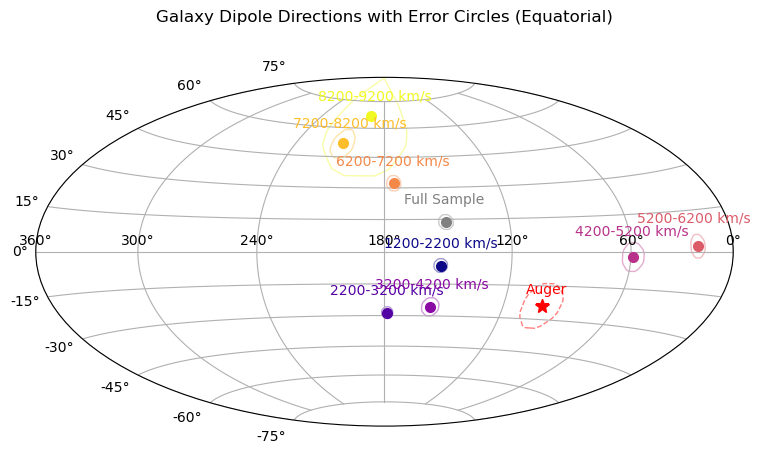

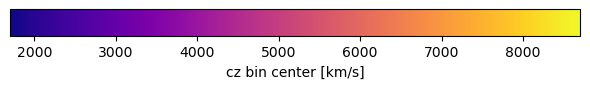

KeyError: 'σ_sep'

In [46]:
import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.special import erfinv
import matplotlib.cm as cm
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from astropy.cosmology import FlatLambdaCDM

def read_catalog(path='../data/', 
                 name='2mrs_1175_done.dat', ncols=29):
  
  with open(path+name, 'r') as file:
    archivo = file.readlines()
    header  = [a.replace('#','').split() for a in archivo[:10]]
    lines   = archivo[10:]
  
  columns = header[-1]
  assert(len(columns) == ncols)
  print("Read %s\nColumns:" % name)
  print(columns)
  
  g = [[] for _ in range(ncols)]     
  for line in lines:
    values = line.split()
    g[0].append(            values[0]);   g[1].append(np.float32(values[1]));   g[2].append(np.float32(values[2]));
    g[3].append(np.float32( values[3]));  g[4].append(np.float32(values[4]));   g[5].append(np.float32(values[5]));
    g[6].append(np.float32( values[6]));  g[7].append(np.float32(values[7]));   g[8].append(np.float32(values[8]));
    g[9].append(np.float32( values[9]));  g[10].append(np.float32(values[10])); g[11].append(np.float32(values[11]));
    g[12].append(np.float32(values[12])); g[13].append(np.float32(values[13])); g[14].append(np.float32(values[14]));
    g[15].append(np.float32(values[15])); g[16].append(np.float32(values[16])); g[17].append(np.float32(values[17]));
    g[18].append(np.float32(values[18])); g[19].append(np.float32(values[19])); g[20].append(np.float32(values[20]));
    g[21].append(           values[21]) ; g[22].append(           values[22]);  g[23].append(values[23]); g[24].append(np.int32(values[24]));
    g[25].append(np.int32(  values[25])); g[26].append(           values[26]);  g[27].append(values[27]); g[28].append(         values[28])
  
  data = Table()
  for idx, col in enumerate(columns):
    data[col] = np.array(g[idx])

  data = data[data['v'] > 1200]  # Filter out galaxies with negative cz values

  # Create ks column for K-band absolute magnitude
  from astropy.constants import c
  cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)
  comoving_dist = cosmo.comoving_distance((data['v']*u.km/u.s)/c) 
  data['ks']  = data['k_tc'] - 25 - 5*np.log10(comoving_dist.value*(1 + (data['v']*u.km/u.s)/c))  # K-band absolute magnitude

  data['_RAJ2000'] = data['RAdeg']  
  data['_DEJ2000'] = data['DECdeg']  
  data['cz'] = data['v']

  return data

# === Load galaxy catalogue ===
gxs = read_catalog()
RA_all = np.deg2rad(gxs['_RAJ2000'])
Dec_all = np.deg2rad(gxs['_DEJ2000'])
cz_all = gxs['cz']
weights_all = np.ones(len(RA_all))

# === Define cz bins ===
cz_bins = [
    (1200, 9000),       # Full sample
    (1200, 3600),
    (4000, 5000),
    (9000, 9400)
]
cz_bins = [(cz, cz + 1000) for cz in range(1200, 9000, 1000)]
cz_bins.insert(0, (1200, 9000))  # Add full sample as first bin

# === Setup colors and storage ===
n_bins = len(cz_bins)
#colors = cm.get_cmap('tab10', n_bins)
dipole_results = {}
# Normalize cz range for colormap
cz_vals = [0.5 * (cz_min + cz_max) for (cz_min, cz_max) in cz_bins]
cz_norm = mcolors.Normalize(vmin=min(cz_vals[1:]), vmax=max(cz_vals[1:]))  # exclude full sample from colormap range
cmap = cm.plasma  # or try 'viridis', 'turbo', 'cividis'

# === Auger reference dipole ===
auger_RA = 100.0
auger_Dec = -24.0
auger_coord = SkyCoord(ra=auger_RA * u.deg, dec=auger_Dec * u.deg, frame='icrs')
auger_error_deg = 10.0  # Typical uncertainty in Auger dipole direction

# === Loop through bins ===
for i, (cz_min, cz_max) in enumerate(cz_bins):
    label = "Full Sample" if i == 0 else f"{cz_min}-{cz_max} km/s"
    cz_mid = 0.5 * (cz_min + cz_max)
    color = 'gray' if i == 0 else cmap(cz_norm(cz_mid))  # gray for full sample, colormap for bins

    # Filter galaxies
    mask = (cz_all > cz_min) & (cz_all < cz_max)
    RA = RA_all[mask]
    Dec = Dec_all[mask]
    weights = weights_all[mask]

    if len(RA) < 10:
        print(f"Skipping {label} — too few galaxies ({len(RA)})")
        continue

    W = np.sum(weights)

    # === 2D Rayleigh dipole ===
    a_alpha = (2.0 / W) * np.sum(weights * np.cos(RA))
    b_alpha = (2.0 / W) * np.sum(weights * np.sin(RA))
    r_alpha = np.sqrt(a_alpha**2 + b_alpha**2)
    phi_alpha_deg = np.rad2deg(np.arctan2(b_alpha, a_alpha) % (2 * np.pi))

    # === 3D dipole direction ===
    x = np.cos(Dec) * np.cos(RA)
    y = np.cos(Dec) * np.sin(RA)
    z = np.sin(Dec)
    X = np.sum(weights * x)
    Y = np.sum(weights * y)
    Z = np.sum(weights * z)
    norm = np.sqrt(X**2 + Y**2 + Z**2)
    X /= norm
    Y /= norm
    Z /= norm

    dipole_amp = norm / W
    alpha_d = (np.arctan2(Y, X) % (2 * np.pi)) * 180 / np.pi
    delta_d = np.arcsin(Z) * 180 / np.pi

    # === Uncertainty and significance ===
    Weff = W**2 / np.sum(weights**2)                # Effective weight
    sigma_r = np.sqrt(2 / Weff)                     # Uncertainty in radial component
    sigma_phi_deg = np.rad2deg(sigma_r / r_alpha)   # Rough approximation
    sigma_dec_deg = sigma_phi_deg                   # rough approximation
    P_rayleigh = np.exp(-Weff * r_alpha**2 / 4)     # Rayleigh p-value
    Zsig = np.sqrt(2) * erfinv(1 - 2 * P_rayleigh)  # Gaussian significance

    # === Angular separation from Auger dipole ===
    dip_coord = SkyCoord(ra=alpha_d * u.deg, dec=delta_d * u.deg, frame='icrs')
    separation = dip_coord.separation(auger_coord).deg

    # === Store results ===
    dipole_results[label] = {
        'RA': alpha_d,
        'Dec': delta_d,
        'r_alpha': r_alpha,
        'd_perp': dipole_amp,
        'σ_r': sigma_r,
        'σ_phi': sigma_phi_deg,
        'σ_dec': sigma_dec_deg,
        'Z': Zsig,
        'P': P_rayleigh,
        'separation': separation,
        'N': len(RA),
        'color': color
    }

    # === Print result ===
    print(f"\n=== Dipole for {label} ===")
    print(f"N = {len(RA)} galaxies")
    print(f"RA = {alpha_d:.2f}° ± {sigma_phi_deg:.2f}°")
    print(f"Dec = {delta_d:.2f}° ± {sigma_dec_deg:.2f}°")
    print(f"Amplitude = {dipole_amp:.4f}")
    print(f"Significance = {Zsig:.2f} σ (p = {P_rayleigh:.2e})")
    print(f"Angular separation from Auger = {separation:.2f}°")

# === Plot Dipoles ===
plt.figure(figsize=(9, 5))
ax = plt.subplot(111, projection='hammer')
ax.grid(True)

xticks_deg = [360, 300, 240, 180, 120, 60, 0]
xticks_rad = -np.radians(xticks_deg) + np.pi
ax.set_xticks(xticks_rad)
ax.set_xticklabels([f"{d}°" for d in xticks_deg])



for label, res in dipole_results.items():
    ra_rad = np.deg2rad(res['RA'])
    dec_rad = np.deg2rad(res['Dec'])
#    ra_plot = -(ra_rad - np.pi)
    ra_plot = -ra_rad + np.pi  # <- RA increases right to left

    color = res['color']

    amp = res['d_perp']  # Dipole amplitude (scalar)

    # Plot point
    ax.plot(ra_plot, dec_rad, 'o', color=color, label=label, markersize=7)

    # Error circle
    radius = np.deg2rad(res['σ_phi'])
    circle = plt.Circle((ra_plot, dec_rad), radius,
                        transform=ax.transData, edgecolor=color,
                        facecolor='none', alpha=0.4)
    ax.add_patch(circle)

    ax.text(ra_plot, dec_rad + 0.15, label, ha='center', color=color)


# === Auger Dipole ===
auger_ra_rad = np.deg2rad(auger_RA)
auger_dec_rad = np.deg2rad(auger_Dec)
#auger_ra_plot = -(auger_ra_rad - np.pi)
auger_ra_plot = -np.deg2rad(auger_RA) + np.pi
ax.plot(auger_ra_plot, auger_dec_rad, 'r*', markersize=10, label='Auger Dipole')

# Auger error circle
auger_radius = np.deg2rad(auger_error_deg)
circle = plt.Circle((auger_ra_plot, auger_dec_rad), auger_radius,
                    transform=ax.transData, edgecolor='red',
                    facecolor='none', linestyle='--', alpha=0.5)
ax.add_patch(circle)

ax.text(auger_ra_plot, auger_dec_rad + 0.1, "Auger", ha='center', color='red')

#plt.text(-3.1, -1.8, "Arrow length ∝ Dipole amplitude", fontsize=9)

plt.title("Galaxy Dipole Directions with Error Circles (Equatorial)", pad=40)
#plt.legend(loc='lower left', fontsize='small')
#plt.tight_layout()
#plt.show()

# === Add cz colorbar ===
fig, ax_cb = plt.subplots(figsize=(6, 1))
cb1 = cm.ScalarMappable(norm=cz_norm, cmap=cmap)
cbar = plt.colorbar(cb1, cax=ax_cb, orientation='horizontal')
cbar.set_label("cz bin center [km/s]")
plt.tight_layout()
plt.show()

# === Plot dipole amplitude and angular distance vs cz bin center ===
cz_bin_centers = []
angular_separations = []
angular_separations_err = []
dipole_amps = []
dipole_amps_err = []
ang_diam_dists = []

for label, res in dipole_results.items():
    if label == "Full Sample":
        continue

    cz_range = [int(x.strip().split()[0]) for x in label.split('-')[0:2]]
    cz_mid = 0.5 * (cz_range[0] + cz_range[1])
    cz_bin_centers.append(cz_mid)

    angular_separations.append(res['separation'])
    angular_separations_err.append(res['σ_sep'])
    dipole_amps.append(res['d_perp'])
    dipole_amps_err.append(res['σ_r'])

    z = cz_mid / 3e5
    ang_diam_dists.append(cosmo.angular_diameter_distance(z).value)

# === Plot with error bars ===
fig, axs = plt.subplots(2, 1, figsize=(7, 6), sharex=True)

# Top panel: angular distance to Auger
axs[0].errorbar(
    cz_bin_centers, angular_separations, yerr=angular_separations_err,
    fmt='o-', capsize=3, color='tab:blue', label='Angular Distance'
)
axs[0].set_ylabel("Angular Distance to Auger [deg]")
axs[0].grid(True)

# Bottom panel: dipole amplitude
axs[1].errorbar(
    cz_bin_centers, dipole_amps, yerr=dipole_amps_err,
    fmt='s-', capsize=3, color='tab:green', label='Dipole Amplitude'
)
axs[1].set_xlabel("cz bin center [km/s]")
axs[1].set_ylabel("Dipole Amplitude")
axs[1].grid(True)

plt.tight_layout()
plt.show()
